In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
data = pd.read_csv("../data/house_data.csv")
print(data.info())
# 去除有Nan的数据
tmp = data.dropna(axis=0, how="any")
print(tmp.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21600 non-null  float64
 2   bathrooms      21603 non-null  float64
 3   sqft_living    21613 non-null  float64
 4   sqft_lot       21613 non-null  float64
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  float64
 7   condition      21613 non-null  float64
 8   grade          21613 non-null  float64
 9   sqft_above     21613 non-null  float64
 10  sqft_basement  21613 non-null  float64
 11  yr_built       21613 non-null  float64
 12  lat            21613 non-null  float64
 13  long           21613 non-null  float64
 14  Unnamed: 14    21613 non-null  float64
dtypes: float64(15)
memory usage: 2.5 MB
None
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
fl

In [210]:
data = tmp.values.copy()
print(data.shape)
# 切割数据
y = data[:, 0]
x = data[:, 1:]
print(y.shape)
print(x.shape)
print(x[0, :])

(21597, 15)
(21597,)
(21597, 14)
[ 3.0000e+00  1.0000e+00  1.3400e+03  5.6500e+03  1.0000e+00  0.0000e+00
  3.0000e+00  7.0000e+00  1.1800e+03  0.0000e+00  1.9550e+03  4.7510e+01
 -1.2226e+02  1.9550e+03]


In [211]:
from  sklearn import preprocessing
y=y.reshape(-1,1)
print(y.shape)
data=preprocessing.MinMaxScaler().fit_transform(x)
label=preprocessing.MinMaxScaler().fit_transform(y)
np.savez("house_norm.npz", data=data, label=label)
print(data[0,:])

(21597, 1)
[0.0625     0.06666667 0.16193426 0.00574235 0.         0.
 0.5        0.4        0.08960177 0.         0.47826087 0.56451613
 0.21666667 0.47826087]


epoch : 0 train_loss: 0.0029324095230549574, test_loss: 0.0026646177284419537
epoch : 1 train_loss: 0.0027055288664996624, test_loss: 0.002660362981259823
epoch : 2 train_loss: 0.002674637595191598, test_loss: 0.0024912438821047544
epoch : 3 train_loss: 0.0026578884571790695, test_loss: 0.002443581121042371
epoch : 4 train_loss: 0.002640020800754428, test_loss: 0.002484953496605158
epoch : 5 train_loss: 0.002678541000932455, test_loss: 0.0034975481685250998
epoch : 6 train_loss: 0.0026064037811011076, test_loss: 0.0033329215366393328
epoch : 7 train_loss: 0.0027025938034057617, test_loss: 0.0024890832137316465
epoch : 8 train_loss: 0.0027196649461984634, test_loss: 0.0028890648391097784
epoch : 9 train_loss: 0.0026116720400750637, test_loss: 0.0024672236759215593
epoch : 10 train_loss: 0.0026608267799019814, test_loss: 0.002420061267912388
epoch : 11 train_loss: 0.0026849762070924044, test_loss: 0.002533279825001955
epoch : 12 train_loss: 0.002617339137941599, test_loss: 0.002447016770

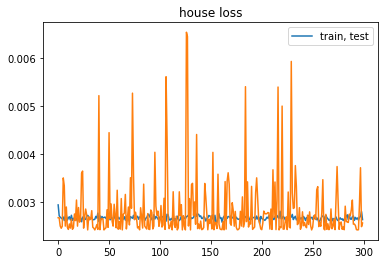

In [212]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from torch.optim import Adam


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(in_features=14, out_features=32),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=32, out_features=16),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=16, out_features=8),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=8, out_features=4),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=4, out_features=1),
        )

    def forward(self, x):
        return self.model(x)


batch_size = 16
train_data_x, test_data_x = torch.utils.data.dataset.random_split(data, [17278, 4319],
                                                                  generator=torch.Generator().manual_seed(42))
train_data_y, test_data_y = torch.utils.data.dataset.random_split(label, [17278, 4319],
                                                                  generator=torch.Generator().manual_seed(42))
train_data = TensorDataset(torch.FloatTensor(train_data_x), torch.FloatTensor(train_data_y))
test_x, test_y = torch.FloatTensor(test_data_x), torch.FloatTensor(test_data_y)
train_data = DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True
)
model = Model()
MSEloss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=0.1)
max_epoch = 300

test_loss = []
train_loss = []
for epoch in range(max_epoch):
    epoch_loss = []
    for step, (batch_x, batch_y) in enumerate(train_data):
        pred = model(batch_x)
        loss = MSEloss(pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.cpu().data)
        #print(f"epoch: {epoch}, iter : {step}, loss: {loss.cpu().data}")
    test_pred = model(test_x)
    loss = MSEloss(test_pred, test_y)
    test_loss.append(loss.cpu().data)
    train_loss.append(np.mean(epoch_loss))
    print(f"epoch : {epoch} train_loss: {np.mean(epoch_loss)}, test_loss: {loss.cpu().data}")

plt.plot([i for i in range(max_epoch)], train_loss)
plt.plot([i for i in range(max_epoch)], test_loss)
plt.title("house loss")
plt.legend(["train, test"])
plt.show()

